Importing Libraries

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
import PIL
import random

/home/bsusheelkumar/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transforming Image Data To Tensors and Augumentation

In [2]:
transform = transforms.Compose([transforms.RandomRotation(30),transforms.RandomAffine(30),transforms.ToTensor()])

Getting Data into Train and Test

In [3]:
# MNIST dataset (images and labels)
train_dataset = MNIST(root='data/', 
                train=True,
                transform=transform)
valid_dataset = MNIST(root='data/', 
                train=False,
                transform=transform)
print(f"Lenght of training dataset is {len(train_dataset)} and Length of validation dataset is {len(valid_dataset)}")

Lenght of training dataset is 60000 and Length of validation dataset is 10000


checking the shape of the Image

In [4]:
img_tensor, label = train_dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


Plotting Images

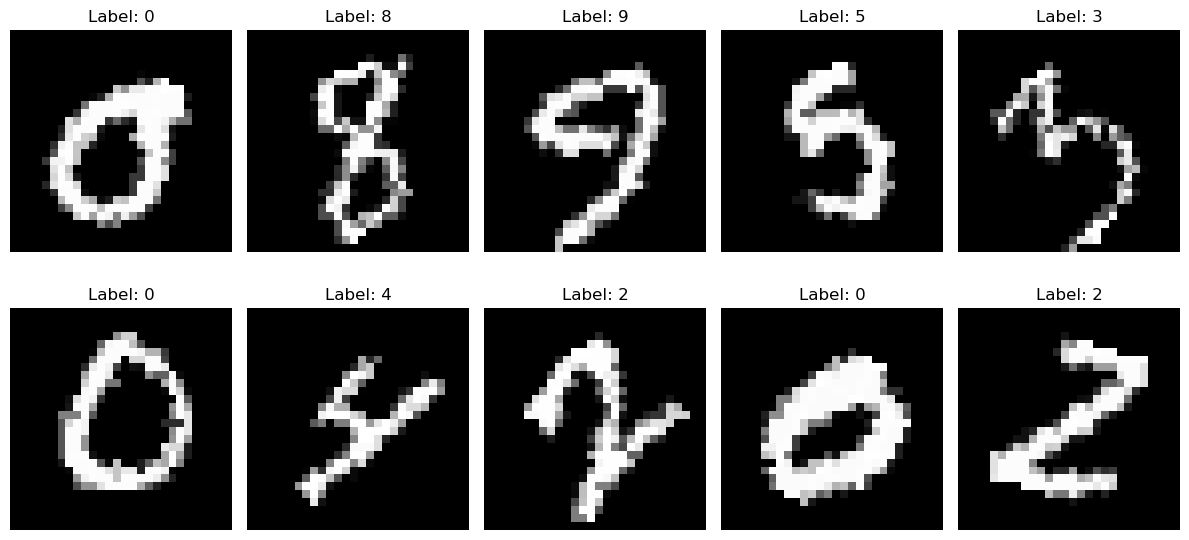

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.flatten()

indices = random.sample(range(len(train_dataset)), 10)

for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    axs[i].imshow(image.squeeze().numpy(), cmap='gray')
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Getting The Data Into Train Loader and Test Loader

In [6]:
train_dl = DataLoader(train_dataset,batch_size=100,shuffle=True)
valid_dl = DataLoader(valid_dataset,batch_size=100*2)

Creating the Model Architecture

In [7]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers with batch normalization and ReLU activation
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layers with dropout and ReLU activation
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.classifier(x)
        return x


Creating an Object of the Model

In [8]:
model = CNN()

Moving the model to GPU

In [21]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
print(model)

cuda
RecursiveScriptModule(
  original_name=CNN
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=MaxPool2d)
    (4): RecursiveScriptModule(original_name=Conv2d)
    (5): RecursiveScriptModule(original_name=BatchNorm2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=MaxPool2d)
    (8): RecursiveScriptModule(original_name=Conv2d)
    (9): RecursiveScriptModule(original_name=BatchNorm2d)
    (10): RecursiveScriptModule(original_name=ReLU)
    (11): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Dropout)


Training The Model for 10 EPOCHS

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dl)
    train_accuracy = correct_train / total_train

    model.eval()
    correct_valid = 0
    total_valid = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()
    val_accuracy = correct_valid / total_valid
    val_loss /= len(valid_dl)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")

    # Store values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


Epoch 1/10, Training Loss: 0.3515, Training Accuracy: 0.8895, Validation Loss: 0.1414, Validation Accuracy: 0.9579
Epoch 2/10, Training Loss: 0.1546, Training Accuracy: 0.9549, Validation Loss: 0.0906, Validation Accuracy: 0.9702
Epoch 3/10, Training Loss: 0.1225, Training Accuracy: 0.9638, Validation Loss: 0.0824, Validation Accuracy: 0.9753
Epoch 4/10, Training Loss: 0.1016, Training Accuracy: 0.9703, Validation Loss: 0.0600, Validation Accuracy: 0.9800
Epoch 5/10, Training Loss: 0.0985, Training Accuracy: 0.9718, Validation Loss: 0.0724, Validation Accuracy: 0.9790
Epoch 6/10, Training Loss: 0.0859, Training Accuracy: 0.9751, Validation Loss: 0.0613, Validation Accuracy: 0.9823
Epoch 7/10, Training Loss: 0.0800, Training Accuracy: 0.9772, Validation Loss: 0.0654, Validation Accuracy: 0.9809
Epoch 8/10, Training Loss: 0.0805, Training Accuracy: 0.9768, Validation Loss: 0.0520, Validation Accuracy: 0.9837
Epoch 9/10, Training Loss: 0.0755, Training Accuracy: 0.9788, Validation Loss: 0

Plotting Graphs

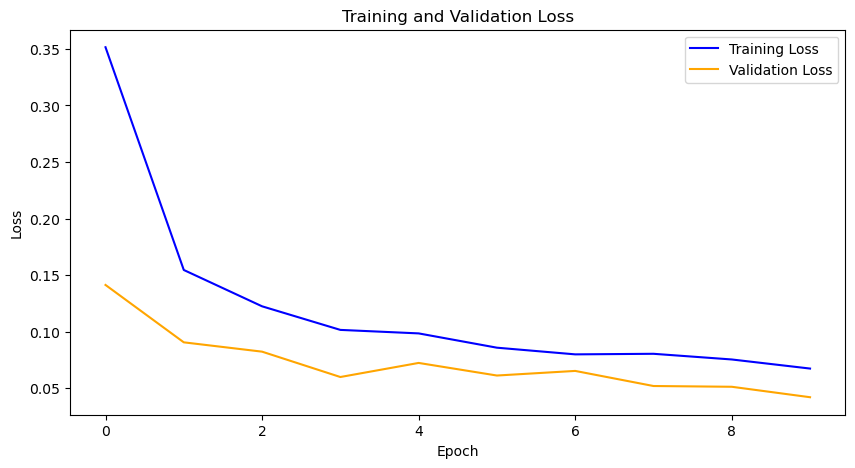

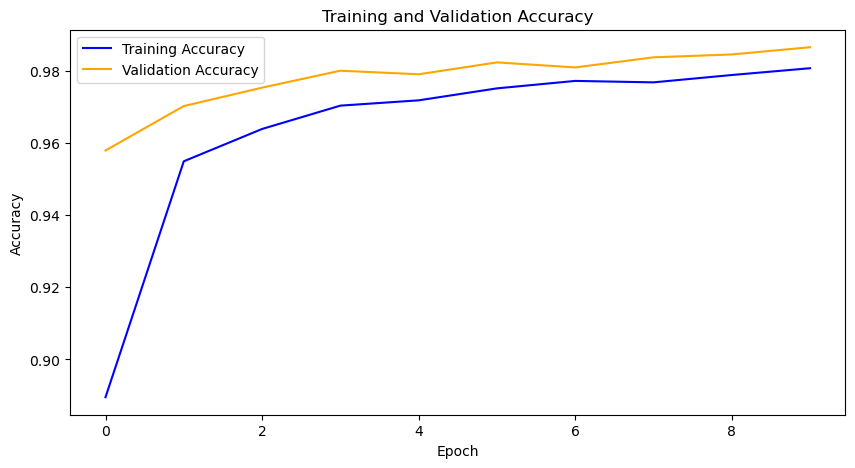

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Displaying Misclassified Samples

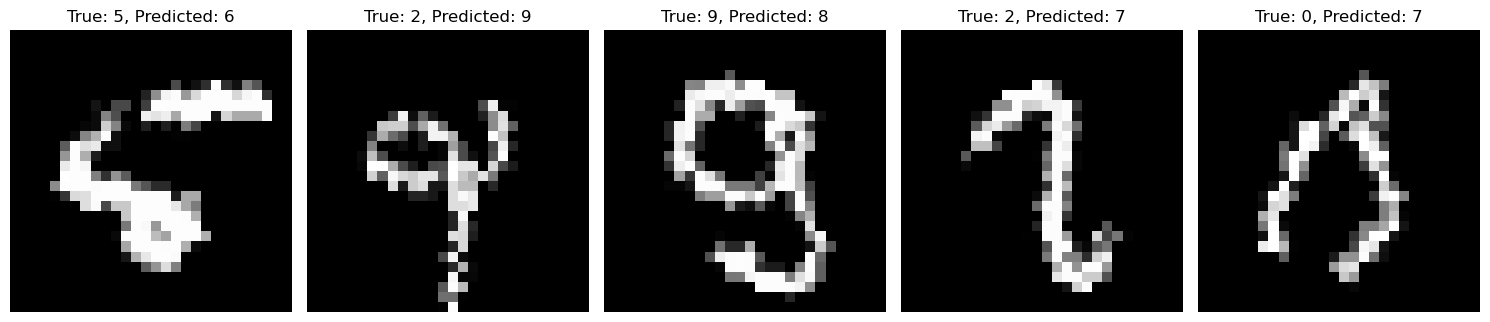

In [17]:
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in valid_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        misclassified_idx = (predicted != labels).nonzero()
        for idx in misclassified_idx:
            misclassified_images.append(images[idx].cpu().squeeze().numpy())
            misclassified_labels.append(labels[idx].cpu().item())
            misclassified_predictions.append(predicted[idx].cpu().item())

num_misclassified = min(len(misclassified_images), 5)
plt.figure(figsize=(15, 5))
for i in range(num_misclassified):
    plt.subplot(1, num_misclassified, i + 1)
    plt.imshow(misclassified_images[i], cmap='gray')
    plt.title(f'True: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Saving the Model

In [18]:

model_scripted = torch.jit.script(model)

model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt') 

Loading the Model

In [19]:
model = torch.jit.load('model_scripted.pt')

Evaluating using the Saved Model

In [20]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in valid_dl:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 98 %
